## <b>ARIMA

ARIMA, also known as the Box-Jenkins model, is a generalization of the ARMA model by including integrated components. 

The integrated components are useful when data has non-stationarity, and the integrated part of ARIMA helps in reducing the non-stationarity. 

The ARIMA applies differencing on time series one or more times to remove non- stationarity effect. 

The ARIMA(p, d, q) represent the order for AR, MA, and differencing components. The major difference between ARMA and ARIMA models is the d (differencing) component, which updates the series on which forecasting model is built. The d component aims to de- trend the signal to make it stationary and ARMA model can be applied to the de-trended dataset.

In [1]:
# Load Modules
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# Function to plot signal, ACF and PACF
def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags=50, ax=ax_acf)
    plot_pacf(xt, lags=50, ax=ax_pacf)
    plt.tight_layout()
    return None

In [3]:
# Read data from Excel file
djia_df = pd.read_excel(
    '../Data Files/DJIA_Jan2016_Dec2016.xlsx'
, parse_dates=['Date'], index_cols=['Date'])

# Dispay the data
djia_df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


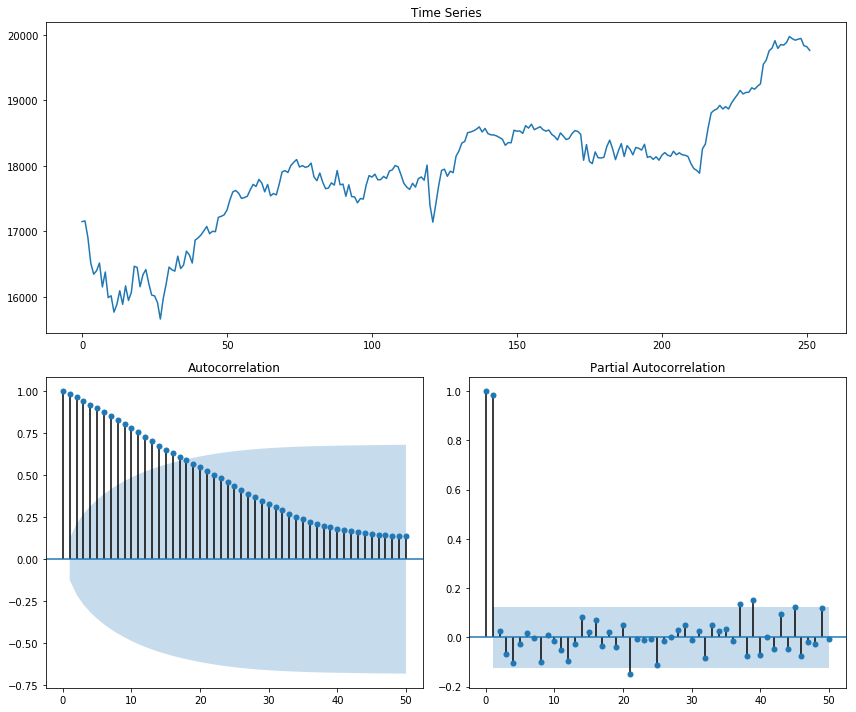

In [4]:
# Plot ACF and PACF
djia_df=djia_df.dropna()
plotds(djia_df['Close'], nlag=50)

The dataset clearly shows a non-stationary signal with an increasing trend. The ACF is also showing an exponential decay while PACF has a strong correlation in lag 2. The non- stationarity can also be checked by evaluating mean and variance in different time periods. The difference in mean and variance validates the hypothesis of non-stationarity. 

In [5]:
# Evaluate mean and variance at mid values
mean1, mean2 =djia_df.iloc[:125].Close.mean(), djia_df.iloc[125:].Close.mean()
var1, var2 = djia_df.iloc[:125].Close.var(), djia_df.iloc[125:].Close.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=17226.579164, mean2=18616.603593
variance1=487045.734003, variance2=325183.639530


In [6]:
# ADF Test
adf_result= adfuller(djia_df.Close.tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -0.462320
p-value: 0.899162


p value too high, so null hypothesis is not rejected and hence the data is non-stationary. Differencing will help make the signal stationary.

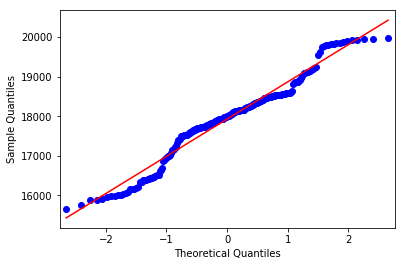

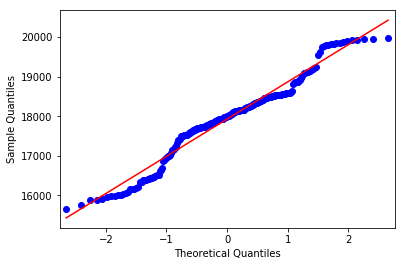

In [7]:
# QQ plot and probability plot
sm.qqplot(djia_df['Close'], line='s')

In [8]:
# Most of the core packages written in Python check for the stationarity within a dataset. 
# In case stationarity is not satisfied, an error is raised. 
# Let's try to force fit an ARMA(1,1) model on the current dataset:
# Optimize ARMA parameters (Will return a non-stationary error)
arma_obj = smtsa.ARMA(djia_df['Close'].tolist(), order=(1, 1)).fit(maxlag=30, method='mle', trend='nc')

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

Text(0.5,1,'First-order differences of DJIA during Jan 2016-Dec 2016')

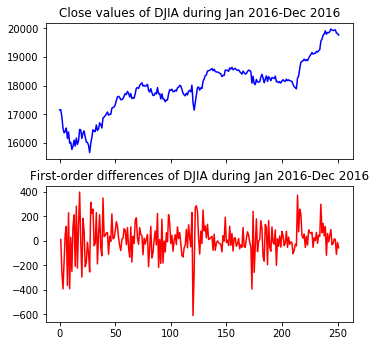

In [9]:
# Differencing will help make the signal stationar
# Let us plot the original time series and first-differences
first_order_diff = djia_df['Close'].diff(1).dropna()
fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(5.5, 5.5)
djia_df['Close'].plot(ax=ax[0], color='b')
ax[0].set_title('Close values of DJIA during Jan 2016-Dec 2016')
first_order_diff.plot(ax=ax[1], color='r')
ax[1].set_title('First-order differences of DJIA during Jan 2016-Dec 2016')

ADF Statistic: -17.135094
p-value: 0.000000


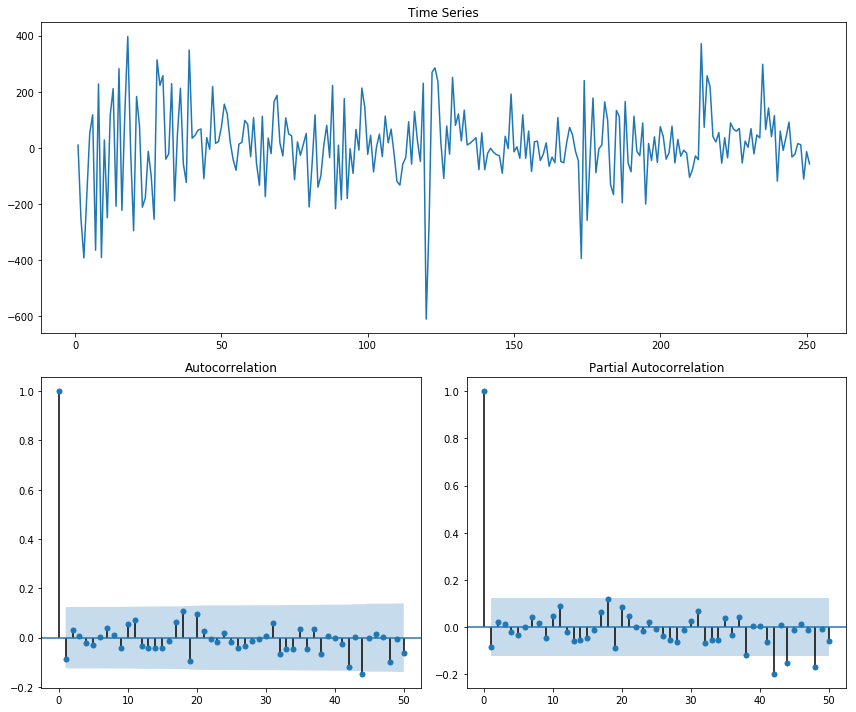

In [10]:
# plot firt order differnced signal
plotds(first_order_diff, nlag=50)
adf_result= adfuller(first_order_diff)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

p value too low, so null hypothesis is rejected and hence the data is stationary.

In [11]:
# Optimize ARMA parameters
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(djia_df['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
            
aicVal

/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

[[0, 1, 0, 3182.6357271384236],
 [0, 1, 1, 3182.9315503221464],
 [0, 1, 2, 3184.6622787227266],
 [1, 1, 0, 3182.8371527798513],
 [1, 1, 1, 3184.736151494834],
 [2, 1, 0, 3184.6953587013154],
 [2, 1, 1, 3186.7685269831472],
 [2, 1, 2, 3188.712545497453],
 [0, 2, 0, 3364.451294991992],
 [0, 2, 1, 3177.7694610653907],
 [1, 2, 0, 3274.73489774239],
 [1, 2, 1, 3177.9953047588097],
 [1, 2, 2, 3179.888767565004],
 [2, 2, 0, 3242.2476970129246],
 [2, 2, 1, 3179.8412853304635],
 [2, 2, 2, 3180.9383046441308]]

As AIC between models are very close, it is recommended to use a subject matter expert to pick the right model. Let's pick ARIMA(0,2,1) for model fitting and evaluation. The ARIMA(0,2,1) applies second-order differencing and first-order moving average component to determine the relationship between observations. 

In [12]:
# Optimal ARIMA model
arima_obj = ARIMA(djia_df['Close'].tolist(), order=(0,2,1))
arima_obj_fit = arima_obj.fit(disp=0)
arima_obj_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  250
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1585.885
Method:                       css-mle   S.D. of innovations            136.122
Date:                Sat, 02 May 2020   AIC                           3177.769
Time:                        23:20:47   BIC                           3188.334
Sample:                             2   HQIC                          3182.021
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1011      0.119      0.853      0.395      -0.131       0.334
ma.L1.D2.y    -1.0000      0.012    -81.004      0.000      -1.024      -0.976
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [13]:
# Shape of ARIMA prediction and original time series
#  Because 2nd order differencing
print(len(arima_obj_fit.fittedvalues))
print(djia_df.shape)

250
(252, 7)


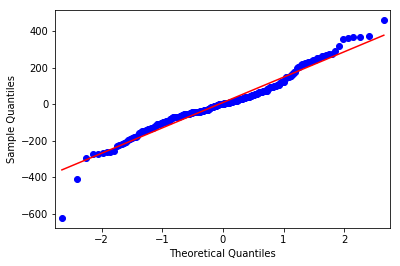

In [14]:
# Evaluate prediction
pred=np.append([0,0],arima_obj_fit.fittedvalues.tolist())
djia_df['ARIMA']=pred
diffval=np.append([0,0], arima_obj_fit.resid+arima_obj_fit.fittedvalues)
djia_df['diffval']=diffval
# QQ plot and probability plot
axarr = sm.qqplot(arima_obj_fit.resid, line='s')

The QQ-normality plot with the ARIMA(0,2,1) model shows significant normality fit

Text(0,0.5,'Closing')

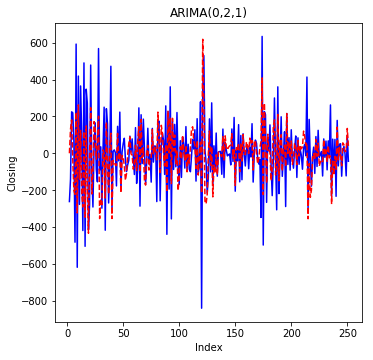

In [15]:
# Plot output
# The comparison with the actual and forecasted values
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)
djia_df['diffval'].iloc[2:].plot(color='b', linestyle = '-', ax=axarr)
djia_df['ARIMA'].iloc[2:].plot(color='r', linestyle = '--', ax=axarr)
axarr.set_title('ARIMA(0,2,1)')
plt.xlabel('Index')
plt.ylabel('Closing')

## <b>SARIMAX
The further extension of the ARIMA model includes the seasonality component for AR, I, and MA represented in capitals. The seasonal ARIMA is represented as ARIMA(p,d,q) (P, D, Q)m, where P, D, and Q represent the seasonal part of auto-regressive, integrated, and moving average, respectively. The m in the seasonal ARIMA model represents the number of periods per season. In scenarios when seasonality is present, the extra steps of seasonal difference and seasonal adjustment may be required to ensure that the signal is stationary. For example, if you look at DJIA difference ACF and PACF plots shown above, the autocorrelation becomes slightly significant at 42 index, which means that there may be seasonality present. 

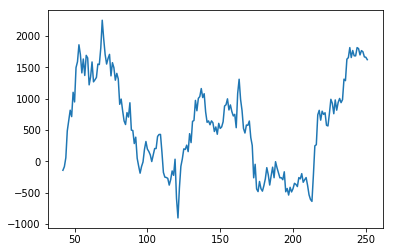

In [16]:
# The seasonality present on first difference and can be seen below
# Seasonality (based on first difference ACF shows significance at 42 lag)
x=djia_df['Close'] - djia_df['Close'].shift(42)
x.plot()

The preceding seasonality can be corrected using seasonal ARIMA supported in the statmodels.SARIMAX model. The script to set up a <b>seasonal ARIMA </b> model for the DJIA dataset is as follows:

In [17]:
# SARIMAX
# Seasonality (based on first difference ACF shows significance at 42 lag)
x=djia_df['Close']-djia_df['Close'].shift(42)
mod = sm.tsa.statespace.SARIMAX(djia_df['Close'], trend='n', order=(0,2,1), seasonal_order=(1,1,1,42))
sarimax= mod.fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  252
Model:             SARIMAX(0, 2, 1)x(1, 1, 1, 42)   Log Likelihood               -1366.570
Date:                            Sat, 02 May 2020   AIC                           2741.141
Time:                                    23:21:10   BIC                           2754.491
Sample:                                         0   HQIC                          2746.539
                                            - 252                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000     16.163     -0.062      0.951     -32.679      30.679
ar.S.L42      -0.2542      0.093     -2.727      0.006      -0.437      -0.072
ma.S.L42      -0.4671      0.130     -3.597      0.000      -0.722      -0.213
sigma2      2.355e+04    3.8e+05      0.062      0.951   -7.22e+05    7.69e+05
===================================================================================
Ljung-Box (Q):                       31.80   Jarque-Bera (JB):                21.28
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## <b> Confidence interval
The confidence level in a forecasting model is defined by the alpha parameter in the forecast function. The alpha value 0.05 represents an estimate with 95% confidence, which can be interpreted as the estimates returned by the model have 5% probability of not falling in the defined distribution range. Zα is the critical value defined based on alpha. For the alpha value 0.05, the critical value is 1.96

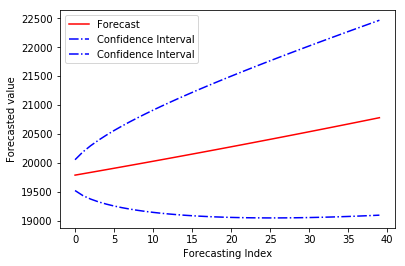

In [18]:
# The confidence interval with an alpha value 0.05 for the DJIA dataset modeled
# using the ARIMA(0,2,1) model can be obtained using the forecast function from the arima_obj_fit object
# Forecasting
f, err, ci=arima_obj_fit.forecast(40)
plt.plot(f, color='r', linestyle = '-', label='Forecast')
plt.plot(ci, color='b', linestyle = '-.', label ='Confidence Interval')
plt.xlabel('Forecasting Index')
plt.ylabel('Forecasted value')
plt.legend()

### <b> Summary
    
- Auto-regressive models such as a MA model to capture serial correlation using error relationship. 
- AR models sets up the forecasting using the lags as dependent observations. The AR models are good to capture trend information. 
- The ARMA-based approach integrates AR and MA models to capture any time-based trends and catastrophic events leading to a lot of error that will take time to correct such as an economy meltdown. 
- ARIMA is proposed, which performs differencing in time series datasets to remove any trend-related components. This model works best in scenarios where stationarity is not present and a differencing-based appriach is required.